In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210101_correlation/"

In [3]:
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000.npy'
cluster_model_labels = np.load(labels_file)

In [4]:
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    final_map = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]

            if p_map[z,cluster_num] <= 1e-8 :
                sig = 1
            else:
                sig = 0

            if len(cluster_indicies) > 100:
                sig = np.nan
            colored_by_betas[cluster_indicies] = r_map[z,cluster_num]*sig
        colored_by_betas = colored_by_betas.reshape(256,128)
        final_map.append(colored_by_betas)
    final_map = np.asarray(final_map)
    maps[behavior] = final_map

In [5]:
norm_min = 0
norm_max = np.max(np.nan_to_num(maps['Y_pos']))
norm_max = 0.15
slices = []
for z in range(49):
    colors1 = Normalize(norm_min, norm_max)(maps['Z_neg'][z,:,:].T)
    colors2 = Normalize(norm_min, norm_max)(maps['Z_pos'][z,:,:].T)
    colors3 = Normalize(norm_min, norm_max)(maps['Y_pos'][z,:,:].T)
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

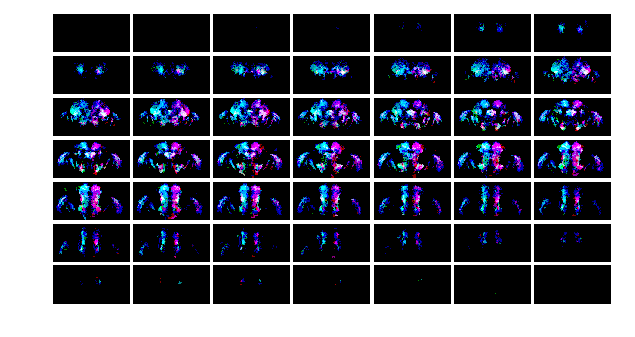

In [44]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(slices[i][:,:,:]*2);
    grid[i].axis('off')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [52]:
np.asarray(slices).shape

(49, 128, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


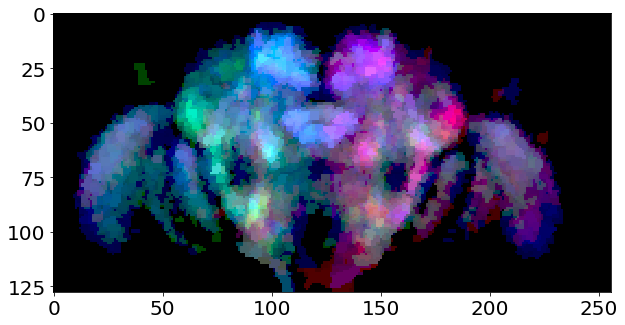

In [56]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(np.nan_to_num(np.asarray(slices)),axis=0))

# Pretty

In [6]:
slices = np.asarray(slices)
slices = np.moveaxis(slices,0,2)
slices.shape

(128, 256, 49, 3)

In [7]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke.nii'
anatomy = np.asarray(nib.load(file).get_data(), dtype='float32')/1
anatomy = np.moveaxis(anatomy,0,1)
anatomy.shape

(512, 1024, 256)

In [ ]:
# Both Y,X,Z - good

#### Interpolate both to be 1um isotropic

In [ ]:
# When I was aligning my functional data to the anatomical average, I resampled the anat down to match the
# dimensions of the functional
# This new space does not have um units of the functional, but actually the anat

In [8]:
anatomy_iso = ants.resample_image(ants.from_numpy(anatomy),(int(512*0.65), int(1024*0.65), int(256*1)),1,0).numpy()

In [9]:
slices_iso = ants.resample_image(ants.from_numpy(slices),(int(512*0.65), int(1024*0.65), int(256*1), 3),1,1,).numpy()

In [80]:
anatomy_iso.shape, slices_iso.shape

((332, 665, 256), (332, 665, 256, 3))

In [10]:
# Alpha Mask
avg_value = np.mean(np.nan_to_num(slices_iso),axis=-1)
mask = np.zeros(np.shape(avg_value))
mask[np.where(avg_value>0)] = 1
to_plot = np.concatenate((slices_iso, mask[:,:,:,np.newaxis]),axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


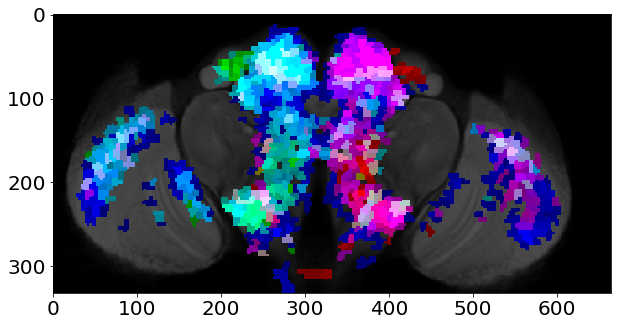

In [525]:
plt.figure(figsize=(10,10))
z=140
plt.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
plt.imshow(to_plot[:,:,z]*2)
#plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [529]:
np.max(to_plot[:,:,:]*2,axis=2).shape

(332, 665, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


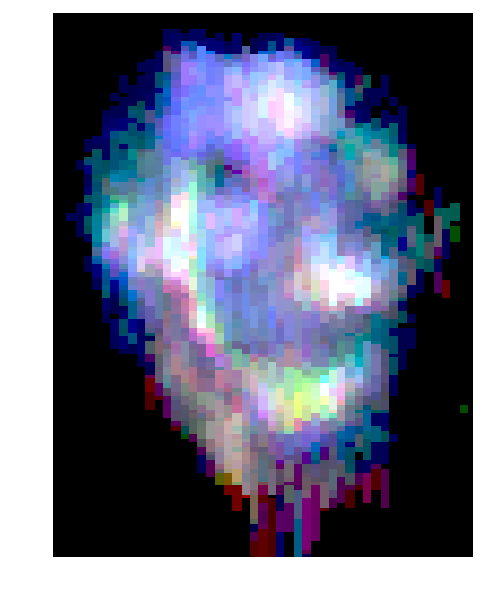

In [544]:
plt.figure(figsize=(10,10))
#plt.imshow(np.max(anatomy_iso,axis=-1),cmap='gray',vmax=3)
plt.imshow(np.max(np.nan_to_num(slices_iso),axis=1)*1.3)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [348]:
# make non-specific-color channels 0

mask = np.zeros(np.shape(slices_iso[:,:,:,0]))
reds = np.concatenate((slices_iso[:,:,:,0,np.newaxis],mask[:,:,:,np.newaxis],mask[:,:,:,np.newaxis]),axis=-1)
greens = np.concatenate((mask[:,:,:,np.newaxis],slices_iso[:,:,:,1,np.newaxis],mask[:,:,:,np.newaxis]),axis=-1)
blues = np.concatenate((mask[:,:,:,np.newaxis],mask[:,:,:,np.newaxis],slices_iso[:,:,:,2,np.newaxis]),axis=-1)

# make background white
reds[np.where(np.nan_to_num(reds[:,:,:,0])==0)] = 1
greens[np.where(np.nan_to_num(greens[:,:,:,1])==0)] = 1
blues[np.where(np.nan_to_num(blues[:,:,:,2])==0)] = 1

In [343]:
from matplotlib.colors import LinearSegmentedColormap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


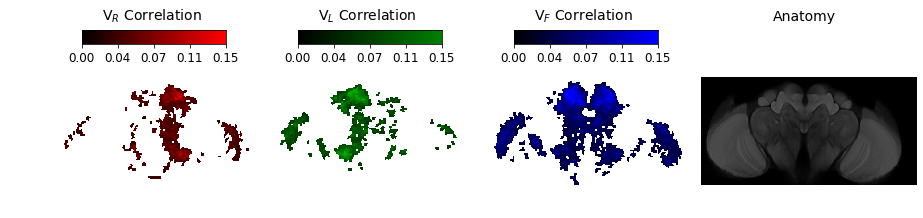

In [400]:
fig = plt.figure(figsize=(10,10))
z=140

ax = fig.add_axes([0,.5,.3,.3])
ax.imshow(reds[:,:,z])
ax.axis('off')

ax = fig.add_axes([.3,.5,.3,.3])
ax.imshow(greens[:,:,z])
ax.axis('off')

ax = fig.add_axes([.6,.5,.3,.3])
ax.imshow(blues[:,:,z])
ax.axis('off')

ax = fig.add_axes([.9,.5,.3,.3])
plt.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
ax.axis('off')

ax = fig.add_axes([0.04,.77,.2,.02])
num_steps = 1000
num_ticks = 5
gradient = np.linspace(norm_min, norm_max, num_steps)
gradient = np.vstack((gradient, gradient))
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'red'])
ax.imshow(gradient, aspect='auto', cmap=cmap)
tick_values = ['{:0.2f}'.format(n) for n in np.linspace(norm_min, norm_max, num_ticks)]
plt.xticks(np.linspace(0,num_steps,num_ticks), tick_values, fontsize=12)
ax.yaxis.set_ticks([])
ax.text(s='V$_R$ Correlation',x=140,y=-2,fontsize=14)

ax = fig.add_axes([0.34,.77,.2,.02])
num_steps = 1000
num_ticks = 5
gradient = np.linspace(norm_min, norm_max, num_steps)
gradient = np.vstack((gradient, gradient))
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'green'])
ax.imshow(gradient, aspect='auto', cmap=cmap)
tick_values = ['{:0.2f}'.format(n) for n in np.linspace(norm_min, norm_max, num_ticks)]
plt.xticks(np.linspace(0,num_steps,num_ticks), tick_values, fontsize=12)
ax.yaxis.set_ticks([])
ax.text(s='V$_L$ Correlation',x=140,y=-2,fontsize=14)

ax = fig.add_axes([0.64,.77,.2,.02])
num_steps = 1000
num_ticks = 5
gradient = np.linspace(norm_min, norm_max, num_steps)
gradient = np.vstack((gradient, gradient))
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'blue'])
ax.imshow(gradient, aspect='auto', cmap=cmap)
tick_values = ['{:0.2f}'.format(n) for n in np.linspace(norm_min, norm_max, num_ticks)]
plt.xticks(np.linspace(0,num_steps,num_ticks), tick_values, fontsize=12)
ax.yaxis.set_ticks([])
ax.text(s='V$_F$ Correlation',x=140,y=-2,fontsize=14)

ax = fig.add_axes([0.94,.77,.2,.02])
ax.text(s='Anatomy',x=.3,y=1.7,fontsize=14)
ax.axis('off')


save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [13]:
og = to_plot.copy()

In [12]:
to_plot.shape

(332, 665, 256, 4)

In [18]:
to_plot = []
for i in range(4):
    to_plot.append(scipy.ndimage.gaussian_filter(og[...,i], sigma=2))
to_plot = np.asarray(to_plot)

In [20]:
to_plot = np.moveaxis(to_plot,0,-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


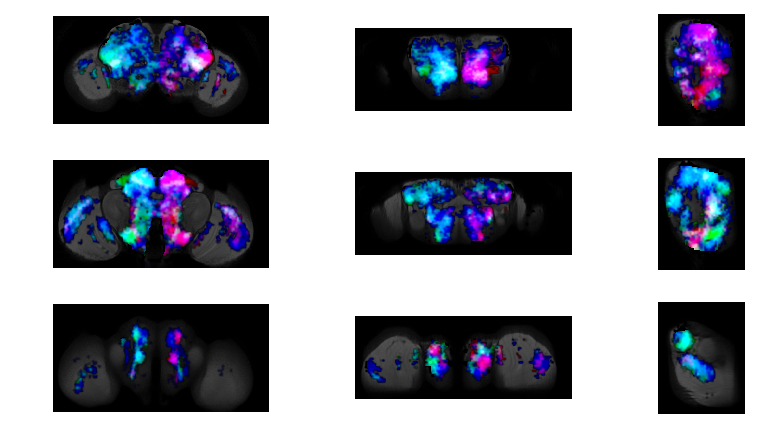

In [22]:
fig = plt.figure(figsize=(10,10))

#############
#### XY #####
#############
ax = fig.add_axes([0,.4,.3,.3])
z=70
ax.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
ax.imshow(to_plot[:,:,z]*2)
ax.axis('off')

ax = fig.add_axes([0,.2,.3,.3])
z=140
ax.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
ax.imshow(to_plot[:,:,z]*2)
ax.axis('off')

ax = fig.add_axes([0,0,.3,.3])
z=200
ax.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
ax.imshow(to_plot[:,:,z]*2)
ax.axis('off')

#############
#### XZ #####
#############
ax = fig.add_axes([.42,.4,.3,.3])
x=70
ax.imshow(np.swapaxes(anatomy_iso[x,:,:],0,1),cmap='gray',vmax=3)
ax.imshow(np.swapaxes(to_plot[x,:,:],0,1)*2)
ax.axis('off')

ax = fig.add_axes([.42,.2,.3,.3])
x=100
ax.imshow(np.swapaxes(anatomy_iso[x,:,:],0,1),cmap='gray',vmax=3)
ax.imshow(np.swapaxes(to_plot[x,:,:],0,1)*2)
ax.axis('off')

ax = fig.add_axes([.42,0,.3,.3])
x=250
ax.imshow(np.swapaxes(anatomy_iso[x,:,:],0,1),cmap='gray',vmax=3)
ax.imshow(np.swapaxes(to_plot[x,:,:],0,1)*2)
ax.axis('off')

#############
#### YZ #####
#############

ax = fig.add_axes([.84,.05,.12,.2])
y=160
ax.imshow(anatomy_iso[:,y,:],cmap='gray',vmax=3)
ax.imshow(to_plot[:,y,:]*2)
ax.axis('off')

ax = fig.add_axes([.84,.25,.12,.2])
y=250
ax.imshow(anatomy_iso[:,y,:],cmap='gray',vmax=3)
ax.imshow(to_plot[:,y,:]*2)
ax.axis('off')

ax = fig.add_axes([.84,.45,.12,.2])
y=360
ax.imshow(anatomy_iso[:,y,:],cmap='gray',vmax=3)
ax.imshow(to_plot[:,y,:]*2)
ax.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 331.5, -0.5)

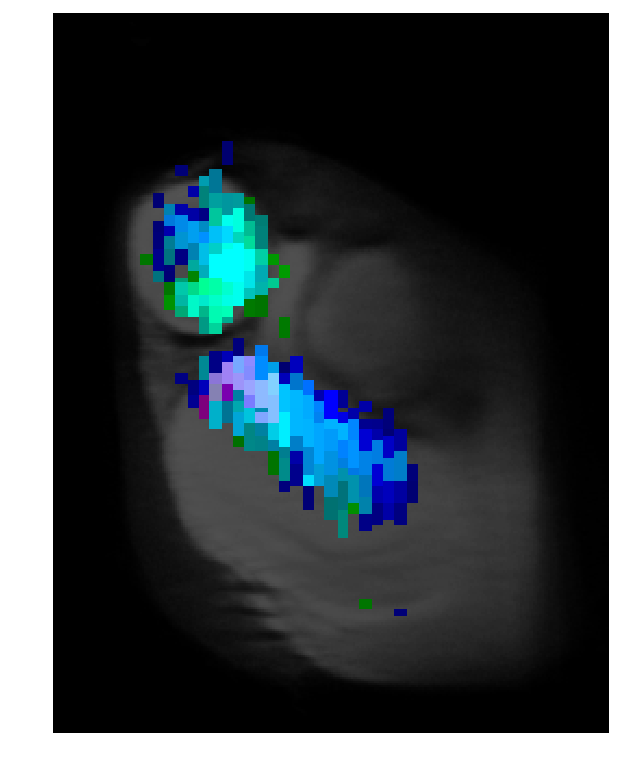

In [520]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([1,1,1,1])
y=160
ax.imshow(anatomy_iso[:,y,:],cmap='gray',vmax=3)
ax.imshow(to_plot[:,y,:]*2)
ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


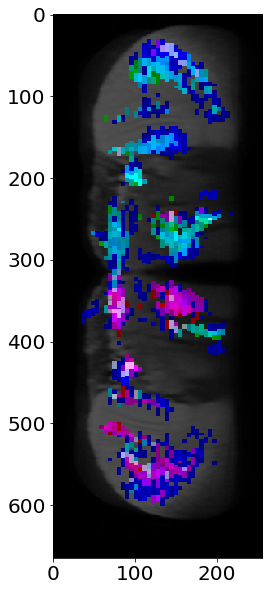

In [161]:
plt.figure(figsize=(10,10))
z=140
plt.imshow(anatomy_iso[200,:,:],cmap='gray',vmax=3)
plt.imshow(to_plot[200,:,:]*2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


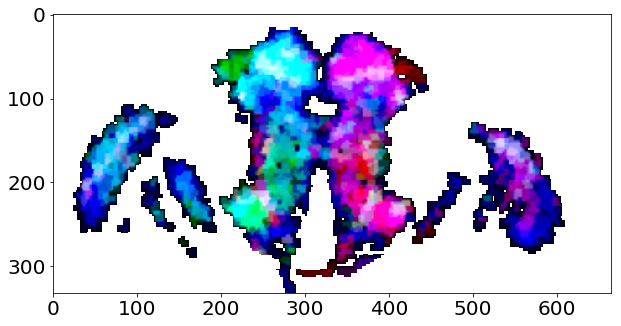

In [145]:
plt.figure(figsize=(10,10))
z=140
#plt.imshow(anatomy_iso[:,:,z],cmap='gray')
plt.imshow(to_plot[:,:,z]*2)

In [108]:
mask.shape

(332, 665, 256)

In [ ]:
fig = plt.figure(figsize=(10,10))

# alpha_min = 0
# alpha_max = .0001
# norm_min = 0
# norm_max = .2

alpha_min = -.9
alpha_max = -.89999
norm_min = -.15
norm_max = .15

### Main Fig ###
ax = fig.add_axes([1,1,1,1])
ax.axis('off')
ax.imshow(anatomy_XY,cmap='gray')
alphas = Normalize(alpha_min, alpha_max, clip=True)(map_XY)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(norm_min, norm_max)(map_XY)
cmap = plt.cm.seismic
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
ax.imshow(colors)
#ax.axhline(165)
#ax.axvline(258)


In [28]:
anatomy_XY = cv2.resize(np.max(anatomy,axis=2), dsize=(int(512*0.65), int(1024*0.65)), interpolation=cv2.INTER_CUBIC).T
anatomy_XZ = cv2.resize(np.max(anatomy,axis=1), dsize=(256, int(1024*0.65)), interpolation=cv2.INTER_CUBIC).T
anatomy_YZ = cv2.resize(np.max(anatomy,axis=0), dsize=(256, int(512*0.65)), interpolation=cv2.INTER_CUBIC)[:,::-1]

map_XY = cv2.resize(np.max(np.nan_to_num(slices),axis=0), dsize=(int(512*0.65), int(1024*0.65)), interpolation=cv2.INTER_NEAREST).T
map_XZ = cv2.resize(np.max(np.nan_to_num(slices),axis=2), dsize=(int(1024*0.65),256), interpolation=cv2.INTER_NEAREST)
map_YZ = cv2.resize(np.max(np.nan_to_num(slices),axis=1), dsize=(int(512*0.65),256), interpolation=cv2.INTER_NEAREST).T[:,::-1]

# map_XY = cv2.resize(np.abs(np.min(np.nan_to_num(final_map),axis=0)), dsize=(int(512*0.65), int(1024*0.65)), interpolation=cv2.INTER_NEAREST).T
# map_XZ = cv2.resize(np.abs(np.min(np.nan_to_num(final_map),axis=2)), dsize=(int(1024*0.65),256), interpolation=cv2.INTER_NEAREST)
# map_YZ = cv2.resize(np.abs(np.min(np.nan_to_num(final_map),axis=1)), dsize=(int(512*0.65),256), interpolation=cv2.INTER_NEAREST).T[:,::-1]

In [29]:
np.shape(map_XY)

(3, 332, 665)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


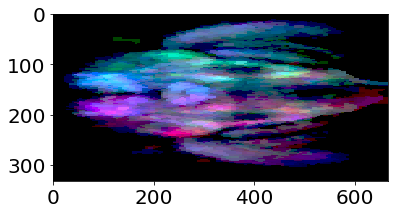

In [33]:
plt.imshow(np.moveaxis(map_XY,0,2))

# Individual Flies

In [16]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke.nii'
anatomy = np.asarray(nib.load(file).get_data(), dtype='float32')/1
anatomy = np.moveaxis(anatomy,0,1)
anatomy_iso = ants.resample_image(ants.from_numpy(anatomy),(int(512*0.65), int(1024*0.65), int(256*1)),1,0).numpy()

In [57]:
root_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210101_correlation"

In [58]:
flies = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

In [59]:
single_maps = {}
for fly in flies:
    print(fly)
    dataset_path = os.path.join(root_path, fly)
    behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
    maps = {}
    for behavior in behaviors:
        rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
        bbb.sort_nicely(rvalues_to_load)

        pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
        bbb.sort_nicely(pvalues_to_load)

        r_map = []
        p_map = []
        for z in range(49):
            r_map.append(np.load(rvalues_to_load[z]))
            p_map.append(np.load(pvalues_to_load[z]))

        r_map = np.asarray(r_map)
        p_map = np.asarray(p_map)

        final_map = []
        for z in range(49):
            colored_by_betas = np.zeros(256*128)
            for cluster_num in range(n_clusters):
                cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]

                if p_map[z,cluster_num] <= 1e-8 :
                #if p_map[z,cluster_num] <= 1e-8 :

                    sig = 1
                else:
                    sig = 1

                if len(cluster_indicies) > 100:
                    sig = np.nan
                colored_by_betas[cluster_indicies] = r_map[z,cluster_num]*sig
            colored_by_betas = colored_by_betas.reshape(256,128)
            final_map.append(colored_by_betas)
        final_map = np.asarray(final_map)
        maps[behavior] = final_map

    norm_min = 0
    norm_max = 0.15
    slices = []
    for z in range(49):
        colors1 = Normalize(norm_min, norm_max)(maps['Z_neg'][z,:,:].T)
        colors2 = Normalize(norm_min, norm_max)(maps['Z_pos'][z,:,:].T)
        colors3 = Normalize(norm_min, norm_max)(maps['Y_pos'][z,:,:].T)
        to_plot = np.stack((colors1,colors2,colors3),axis=2)
        slices.append(to_plot)

    slices = np.asarray(slices)
    slices = np.moveaxis(slices,0,2)

    slices_iso = ants.resample_image(ants.from_numpy(slices),(int(512*0.65), int(1024*0.65), int(256*1), 3),1,1,).numpy()
    # Alpha Mask
    avg_value = np.mean(np.nan_to_num(slices_iso),axis=-1)
    mask = np.zeros(np.shape(avg_value))
    mask[np.where(avg_value>0)] = 1
    to_plot = np.concatenate((slices_iso, mask[:,:,:,np.newaxis]),axis=-1)
    single_maps[fly] = to_plot

fly_087
fly_089
fly_094
fly_097
fly_098
fly_099
fly_100
fly_101
fly_105


In [69]:
flies.insert(0,'meanbrain')
single_maps['meanbrain'] = to_plot # run this above

In [61]:
flies

['fly_087',
 'fly_089',
 'fly_094',
 'fly_097',
 'fly_098',
 'fly_099',
 'fly_100',
 'fly_101',
 'fly_105']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

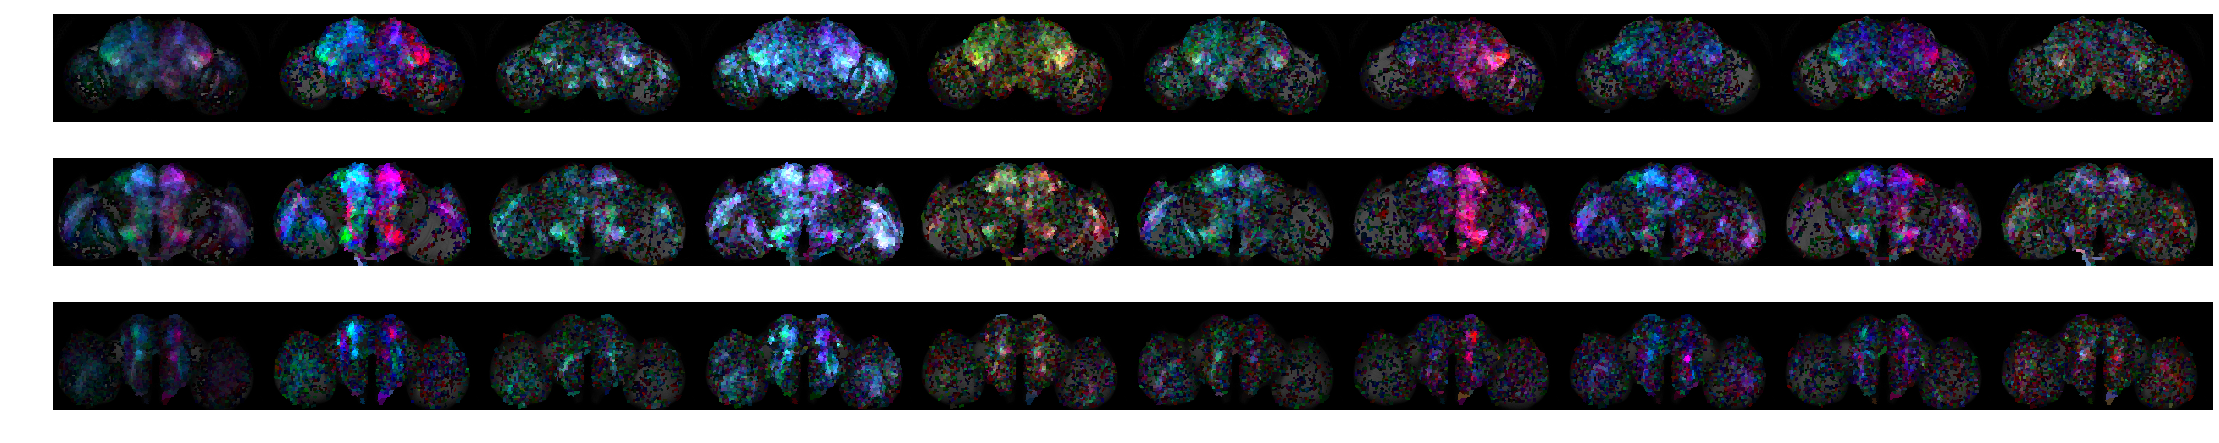

In [71]:
fig = plt.figure(figsize=(10,10))

#############
#### XY #####
#############
for i, fly in enumerate(flies):
    ax = fig.add_axes([0+i*.3,1,.3,.3])
    z=70
    ax.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
    ax.imshow(single_maps[fly][:,:,z])
    ax.axis('off')
    
    ax = fig.add_axes([0+i*.3,.8,.3,.3])
    z=140
    ax.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
    ax.imshow(single_maps[fly][:,:,z])
    ax.axis('off')

    ax = fig.add_axes([0+i*.3,.6,.3,.3])
    z=200
    ax.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
    ax.imshow(single_maps[fly][:,:,z])
    ax.axis('off')
    
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


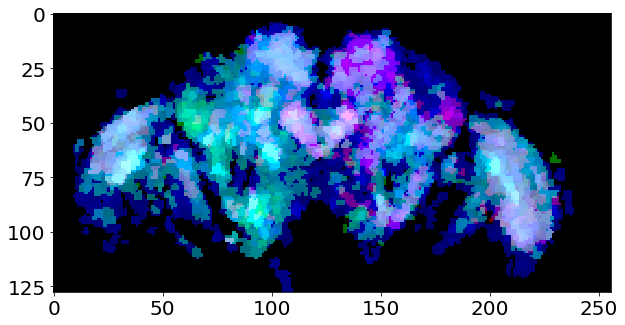

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(np.nan_to_num(np.asarray(slices)),axis=0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

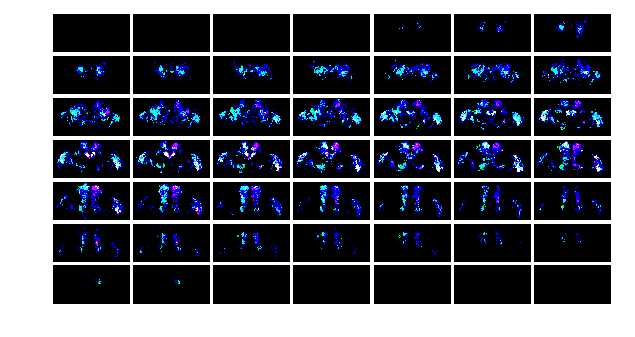

In [16]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(slices[i][:,:,:]*2);
    grid[i].axis('off')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [17]:
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)
brain.shape

(256, 128, 3384, 10)

In [18]:
brain.size

1108869120